## Importing packages

In [22]:
#!pip install tensorflow
#!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   --------- ------------------------------ 71.7/294.9 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import struct
from array import array
from os.path  import join
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn


## Loading data

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)


In [3]:
input_path = 'input/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


## Preprocessing data

In [49]:
x_train_re = np.array(x_train)
y_train_re = np.array(y_train)
x_test_re = np.array(x_test)
y_test_re = np.array(y_test)

In [50]:
x_test_re.shape

(10000, 28, 28)

In [51]:
from sklearn.model_selection import train_test_split
x_train_re, x_val, y_train_re, y_val = train_test_split(x_train_re, y_train_re, test_size = 0.1, random_state=2)

In [52]:
im_w = 28
im_h = 28
im_channels = 1

In [53]:
x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    im_w,
    im_h,
    im_channels
)
x_validation_with_chanels = x_val.reshape(
    x_val.shape[0],
    im_w,
    im_h,
    im_channels
)
x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    im_w,
    im_h,
    im_channels
)
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (54000, 28, 28, 1)
x_validation_with_chanels: (6000, 28, 28, 1)
x_test_with_chanels: (10000, 28, 28, 1)


In [54]:
x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

## Building CNN

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.activations import relu, linear, softmax

In [56]:
model = Sequential()

model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [57]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [61]:
import datetime
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=sparse_categorical_crossentropy,

    metrics=['accuracy'], 
)

In [75]:
history = model.fit(x_train_normalized, y_train_re, epochs=15, validation_data= (x_validation_normalized, y_val), callbacks=[tensorboard_callback])

Epoch 1/15
1688/1688 [==============================] - 181s 107ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0409 - val_accuracy: 0.9927
Epoch 2/15
1688/1688 [==============================] - 185s 110ms/step - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.0371 - val_accuracy: 0.9940
Epoch 3/15
1688/1688 [==============================] - 185s 109ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0292 - val_accuracy: 0.9942
Epoch 4/15
1688/1688 [==============================] - 184s 109ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0257 - val_accuracy: 0.9940
Epoch 5/15
1688/1688 [==============================] - 184s 109ms/step - loss: 0.0199 - accuracy: 0.9940 - val_loss: 0.0289 - val_accuracy: 0.9945
Epoch 6/15
1688/1688 [==============================] - 181s 107ms/step - loss: 0.0204 - accuracy: 0.9945 - val_loss: 0.0349 - val_accuracy: 0.9927
Epoch 7/15
1688/1688 [==============================] - 166s 98ms/step - loss: 0.0196 - accuracy: 0.9944 - val_l

In [77]:
test_loss, test_acc = model.evaluate(x_test_normalized, y_test_re)
print(test_loss)
print(test_acc)

313/313 [==============================] - 4s 13ms/step - loss: 0.0269 - accuracy: 0.9939
0.026875875890254974
0.9939000010490417


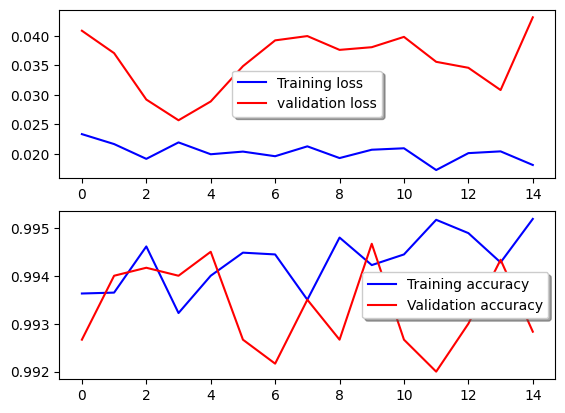

In [78]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

188/188 [==============================] - 2s 12ms/step
Confusion matrix:
[[608   0   1   0   0   0   2   0   2   0]
 [  0 687   0   0   1   1   1   0   1   0]
 [  0   0 566   1   0   0   0   0   2   0]
 [  0   0   0 608   0   2   0   0   1   0]
 [  0   2   0   0 595   0   0   0   0   3]
 [  1   0   0   0   0 557   4   0   0   0]
 [  0   1   0   0   1   1 582   0   0   0]
 [  0   0   1   1   3   0   0 604   0   1]
 [  0   0   1   0   0   0   0   1 587   1]
 [  0   1   0   1   1   3   0   0   0 563]]


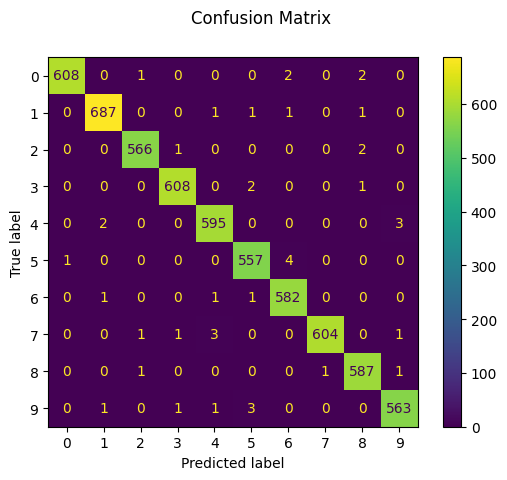

In [93]:
# Look at confusion matrix 
import sklearn

Y_pred = model.predict(x_validation_normalized)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_classes)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
#Y_true = np.argmax(y_val, axis=1) 
#confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [92]:
model_name = 'digits_recognition_cnn.keras'
model.save(model_name, save_format='keras')